In [1]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader import DataLoader

In [ ]:
# tf.test.is_gpu_available()

In [2]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

/depthlearning/DVSDepthLearning/DataLoader.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data_ = h5py.File(filename)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


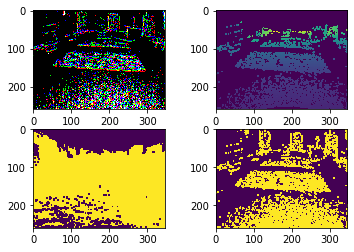

In [3]:
#test batching
data_loader = DataLoader('indoor_flying_augmented.hdf5')

event_images, depth_images, mask_1, mask_2 = data_loader.load_all()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(np.array(event_images[10][:,:,0:3]))
ax.autoscale(True)
ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_images[10]))
ax2.autoscale(True)
ax3 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
ax3.imshow(np.array(mask_1[10]))
ax3.autoscale(True)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax4.imshow(np.array(mask_2[10]))
ax4.autoscale(True)
plt.show()


In [4]:
epochs = 150
batch_size = 6
base_learning_rate = 0.001
learning_decay_rate = 20
learning_decay_factor = 0.5
data_loader = DataLoader('indoor_flying_augmented.hdf5')

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, 9, None, None, 1], name='input_image')
depth_image = tf.placeholder(tf.float32, [None, None, None, 1], name='depth_image')
mask_image_1 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_1')
mask_image_2 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_2')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.vggDecoder_timeseries(input_image, DlModels.vgg11_timeseries)

train_op, loss = TrainDL.NormalizedHuberOptimize(nn_last_layer, depth_image, mask_image_1, mask_image_2, learning_rate)

# Train NN using the train_nn function
TrainDL.train_nn(sess, epochs, batch_size, data_loader, train_op, loss, input_image, depth_image, mask_image_1, mask_image_2, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training...

EPOCH 1 ...
Loss: =
1.3337724375724793

EPOCH 2 ...
Loss: =
0.6133557575941085

EPOCH 3 ...
Loss: =
0.5448706585168839

EPOCH 4 ...
Loss: =
0.5196294790506363

EPOCH 5 ...
Loss: =
0.7356283318996429

EPOCH 6 ...
Loss: =
0.5673122996091843

EPOCH 7 ...
Loss: =
0.5153091365098953

EPOCH 8 ...
Loss: =
0.495447199344635

EPOCH 9 ...
Loss: =
0.3774043273925781

EPOCH 10 ...
Loss: =
0.414266237616539

EPOCH 11 ...
Loss: =
0.3717156746983528

EPOCH 12 ...
Loss: =
0.351505871117115

EPOCH 13 ...
Loss: =
0.3220139691233635

EPOCH 14 ...
Loss: =
0.33580595642328265

EPOCH 15 ...
Loss: =
0.31280303686857225

EPOCH 16 ...
Loss: =
0.305154592692852

EPOCH 17 ...
Loss: =
0.3079480731487274

EPOCH 18 ...
Loss: =
0.30223550021648404

EPOCH 19 ...
Loss: =
0.2906664463877678

EPOCH 20 ...
Loss: =
0.2845289993286133

EPOCH 21 ...
Loss: =
0.26983666062355044

EPOCH 22 ...
Loss: =
0.26867545157670975

EPOCH 23 ...

'./model'

In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


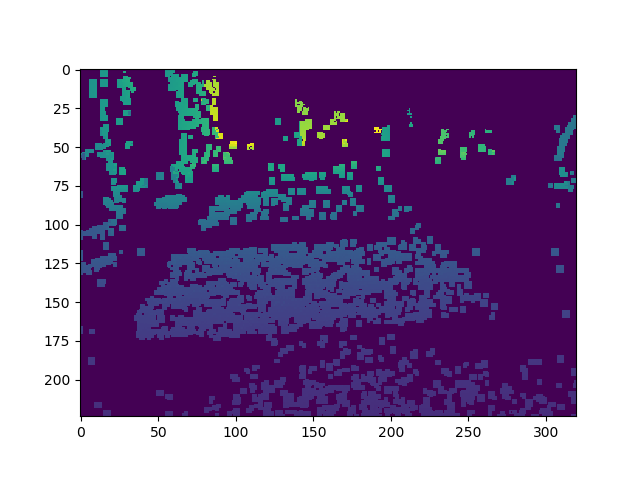

In [26]:
sample_image = [event_images[90][0:224, 0:320, :]]
sample_image = np.swapaxes(sample_image, 0, 3)
sample_image = [np.flip(sample_image, axis=0)]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image})

#plt.imshow(est_depth[0].reshape(target_height, target_width))
plt.imshow(np.multiply(mask_2[90][0:224, 0:320],  est_depth[0].reshape(224, 320)))

In [ ]:
plt.imshow(sample_image[:,:,0])

In [27]:
plt.imshow(depth_images[90][:224,:320])

In [ ]:
#Convert to pointcloud
import open3d
from open3d import geometry
from open3d import visualization
import cv2
g = open3d.camera.PinholeCameraIntrinsic()
g.set_intrinsics(346, 260, 226.0181418548734, 225.7869434267677, 174.5433576736815, 124.21627572590607)

sample_image = event_images[270][0:224, 0:320, :]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image.reshape(1, 224, 320, 9)})

padded_array = np.zeros((260, 346))
padded_array[:224, :320] = np.multiply(mask_2[270][0:224, 0:320],  est_depth[0].reshape(224, 320))
#padded_array[:224, :320] = np.multiply(mask_2[270][0:224, 0:320],  depth_images[270][:224, :320])
image = geometry.Image(np.float32(padded_array))

pointcloud = geometry.PointCloud.create_from_depth_image(image, g, depth_scale=1.0)
visualization.draw_geometries([pointcloud])
open3d.io.write_point_cloud("copy_of_fragment.pcd", pointcloud)

In [ ]:
import numpy as np

g = np.array([[[1,2, 3], [1,2, 3]], [[3,4, 5], [3,4,5]]])

print(g)

np.swapaxes([g], 0,2)
print(g)
print(np.shape(np.swapaxes([g], 0,3)))